In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import adfuller

In [2]:
start = datetime(2002, 1, 1)
end = datetime(2021, 9, 29)

In [3]:
mrin = web.DataReader('MRIN', 'yahoo', start=start, end=end)
mrin

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-03-22,139.649994,113.820000,133.000000,113.820000,1570286.0,113.820000
2013-03-25,116.550003,106.050003,116.550003,111.089996,177743.0,111.089996
2013-03-26,121.660004,112.070000,113.050003,119.279999,49871.0,119.279999
2013-03-27,119.000000,115.430000,119.000000,115.849998,28986.0,115.849998
2013-03-28,116.970001,113.050003,115.919998,115.010002,15871.0,115.010002
...,...,...,...,...,...,...
2021-09-23,8.680000,7.540000,8.050000,8.540000,19136300.0,8.540000
2021-09-24,11.420000,8.220000,8.380000,10.210000,77131700.0,10.210000
2021-09-27,11.150000,9.520000,10.020000,10.500000,21574700.0,10.500000


In [4]:
returns = 100 * mrin.Close.pct_change().dropna()
returns

Date
2013-03-25    -2.398527
2013-03-26     7.372403
2013-03-27    -2.875587
2013-03-28    -0.725072
2013-04-01    -2.678030
                ...    
2021-09-23    -7.274702
2021-09-24    19.555036
2021-09-27     2.840352
2021-09-28   -10.857146
2021-09-29   -10.683761
Name: Close, Length: 2146, dtype: float64

In [5]:
returns.var()

60.107361146839445

In [6]:
result = adfuller(returns)
print('MRIN Returns ADF Test')
print("ADF Statistic: %f" %result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

MRIN Returns ADF Test
ADF Statistic: -16.513720
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Text(0.5, 1.0, 'MRIN Returns')

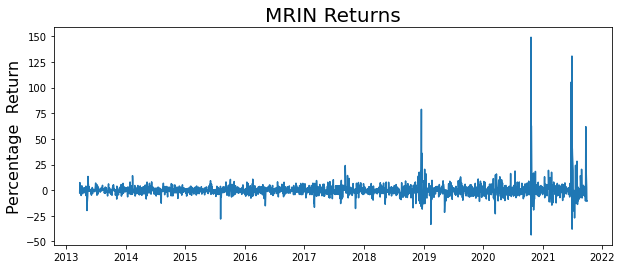

In [7]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Percentage  Return', fontsize=16)
plt.title('MRIN Returns', fontsize=20)

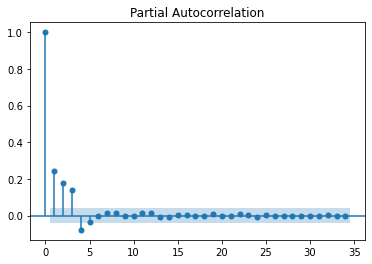

In [8]:
plot_pacf(returns**2)
plt.show()

# Splitting Data

In [9]:
train, test= returns[0:int(len(returns)*0.80)], returns[int(len(returns)*0.80):]

In [10]:
print(len(train))
print(len(test))

1716
430


In [25]:
test

Date
2020-01-16     1.874998
2020-01-17     0.613496
2020-01-21    -8.536585
2020-01-22     0.666666
2020-01-23    -0.662251
                ...    
2021-09-23    -7.274702
2021-09-24    19.555036
2021-09-27     2.840352
2021-09-28   -10.857146
2021-09-29   -10.683761
Name: Close, Length: 430, dtype: float64

In [11]:
rolling_predictions = []
for i in range(len(test)):
    train = returns[:-(len(test)-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.residual_variance.values[-1,:][0]))

C:\Users\wafa\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\wafa\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\wafa\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message.

In [12]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[1716:])
rolling_predictions 

Date
2020-01-16     5.107198
2020-01-17     4.575955
2020-01-21     4.090685
2020-01-22     5.194275
2020-01-23     4.572249
                ...    
2021-09-23    43.895848
2021-09-24    32.083505
2021-09-27    27.066029
2021-09-28    19.776584
2021-09-29    16.100551
Length: 430, dtype: float64

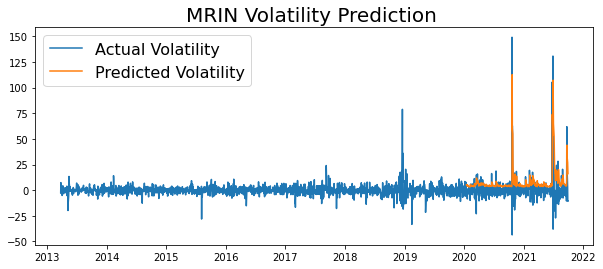

In [13]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns)
preds, = plt.plot(rolling_predictions)
plt.title('MRIN Volatility Prediction ', fontsize=20)
plt.legend(['Actual Volatility', 'Predicted Volatility'], fontsize=16)

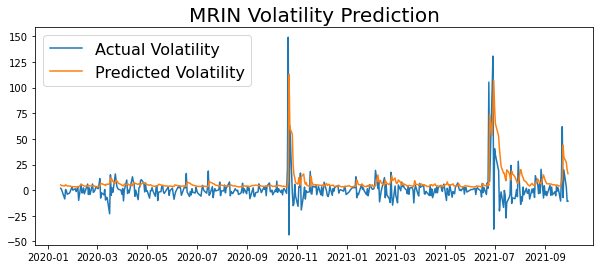

In [15]:
plt.figure(figsize=(10,4))
true, = plt.plot(test)
preds, = plt.plot(rolling_predictions)
plt.title('MRIN Volatility Prediction', fontsize=20)
plt.legend(['Actual Volatility', 'Predicted Volatility'], fontsize=16)

In [22]:
returns[-430:]

Date
2020-01-16     1.874998
2020-01-17     0.613496
2020-01-21    -8.536585
2020-01-22     0.666666
2020-01-23    -0.662251
                ...    
2021-09-23    -7.274702
2021-09-24    19.555036
2021-09-27     2.840352
2021-09-28   -10.857146
2021-09-29   -10.683761
Name: Close, Length: 430, dtype: float64

In [26]:
test

Date
2020-01-16     1.874998
2020-01-17     0.613496
2020-01-21    -8.536585
2020-01-22     0.666666
2020-01-23    -0.662251
                ...    
2021-09-23    -7.274702
2021-09-24    19.555036
2021-09-27     2.840352
2021-09-28   -10.857146
2021-09-29   -10.683761
Name: Close, Length: 430, dtype: float64

In [18]:
rolling_predictions

Date
2020-01-16     5.107198
2020-01-17     4.575955
2020-01-21     4.090685
2020-01-22     5.194275
2020-01-23     4.572249
                ...    
2021-09-23    43.895848
2021-09-24    32.083505
2021-09-27    27.066029
2021-09-28    19.776584
2021-09-29    16.100551
Length: 430, dtype: float64

In [19]:
mse = mean_squared_error(test, rolling_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, rolling_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, rolling_predictions))
print('RMSE: '+str(rmse))

MSE: 331.9169166096479
MAE: 9.667102545038967
RMSE: 18.21858711891918
